# Observability starter for HuggingFace models

This accelerator shows how you can easily enable observability in your <a href='https://huggingface.co/'>HuggingFace</a>-based AI Solutions with DataRobot's LLMOps feature tools. It outlines an example of a byte-sized solution in its current state and then uses DataRobot tools to enable observability almost instantly for the solution.

DataRobot provides tools to enable the observability of external generative models. All the hallmarks of DataRobot MLOps are now available for LLMOps.

## Setup

### Install the prerequisite libraries

This notebook will be using one of the many publicly available <a href='https://huggingface.co/models'>LLMs</a> on Huggingface's hub. HuggingFace's models are available via the popular <a href='https://github.com/huggingface/transformers'>Transformers</a> library. The library provides high level APIs for most common language modeling tasks and solutions.

In [1]:
!pip install transformers torch py-readability-metrics nltk

In [2]:
!pip install datarobotx[llm] datarobot-mlops datarobot-mlops-connected-client "langchain==0.0.335"

## Current state 

The following cells outline the current state of a simple <a href='https://huggingface.co/MBZUAI/LaMini-T5-223M'>Google T5</a> text generation model implementation. Google's T5 is a text sequence to text sequence model and this accelerator uses a distilled version of T5 available on the Huggingface Hub.

This accelerator uses the `pipeline` object from the Transformers library to build a text generation example. The <a href='https://huggingface.co/docs/transformers/main_classes/pipelines'>pipeline</a> object simplifies model inference by abstracting out most of the low level code. To enable observability on this implementation on your own, you would have to write code to take measurements, enable infrastructure to record all the measurements, and codify rules for interventions. This also introduces a lot of technical debt in the organization.
<br>
<br>

In [ ]:
from transformers import pipeline

checkpoint = "MBZUAI/LaMini-T5-223M"
model = pipeline("text2text-generation", model=checkpoint)

parameters = {"max_length": 512, "do_sample": True, "temperature": 0.1}


def get_completion(user_input, parameters):
    answer = model(user_input, **parameters)
    return answer


response = get_completion("What is Agile in software development?", parameters)
print(response[0]["generated_text"])

Agile is a software development methodology that emphasizes the use of software development as a continuous process, with the goal of delivering high-quality, efficient, and cost-effective software products to customers. It involves breaking down tasks into smaller, more manageable tasks, and delivering them in short, incremental increments, with the goal of delivering high-quality, reliable, and user-friendly software.


## Observability with DataRobot
To enable observability on the above T5 model from Huggingface, you first need to create a deployment in DataRobot. This can be done from the GUI or the API based on your preference.

### Connect to DataRobot

In [ ]:
# Initialize the DataRobot Client if you are not running this code outside DataRobot platform.
# import datarobot as dr
# dr.Client(endpoint=ENDPOINT,token=TOKEN)

In [ ]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment(checkpoint + " External")
deployment_id

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'651298b51e720eee4bfdda27'

### Initiate monitoring configuration

The cells below declare and initialize monitoring configuration. The monitoring configuration lets DataRobot understand how to interpret the inputs and outputs of the external model. The `pipeline` object expects text input and named parameters which are configured in the MonitoringConfig object as seen below. 

The <a href="https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig">input_parser</a> object is helpful in capturing and storing the entire input or just the essential parts that you prefer.

In [ ]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda prompt, parameters: {**{"prompt": prompt}, **parameters},
    output_parser=lambda x: {"answer": x[0]["generated_text"]},
    target="answer",
)

In [ ]:
@aguard(monitor_config)
async def get_completion(user_input, parameters):
    answer = model(user_input, **parameters)
    return answer


response = await get_completion("What is Agile in software development?", parameters)
print(response[0]["generated_text"])

Agile is a software development methodology that emphasizes the use of software development as a continuous process, with the goal of delivering high-quality, efficient, and cost-effective software products to customers. It involves breaking down tasks into smaller, more manageable tasks, and delivering them in short, incremental increments, rather than a fixed-size, standardized schedule.


In [ ]:
response = await get_completion("What is a kulbit maneuver?", parameters)
print(response[0]["generated_text"])

A kulbit maneuver is a type of maneuver where a person lands on a surface with a curved or curved surface, and then lands on a surface with a curved or curved surface.


## Custom metrics

Observability with DataRobot also supports <a href='https://docs.datarobot.com/en/docs/mlops/deployment-settings/custom-metrics-settings.html'>custom user metrics</a>. The following cells show how you can start capturing toxicity in user prompts and readability in generative model responses. Add the custom metrics in the cell below that you want to record to your deployment. Again, this step can be done using the GUI or the API based on user preference. <br>
- Toxicity in the user prompt <br>
- Readability (Flesch Score) of the model response 

In [ ]:
from utilities import create_custom_metric

TOX_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Prompt Toxicity",
    baseline="0.1",
    type="average",
    directionality="lowerIsBetter",
)

READ_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="30",
    type="average",
    directionality="higherIsBetter",
)

### Update the Huggingface completion endpoint

Modify the prediction function to add code that calculates the metrics and submits them to the deployment. Now, whenever the prediction is requested from the distilled T5 model, the metrics are calculated and submitted on the deployment enabling you to monitor and intervene as necessary.

In [ ]:
from utilities import get_flesch_score, get_text_texicity, submit_custom_metric


@aguard(monitor_config)
async def get_completion(user_input, parameters):
    answer = model(user_input, **parameters)
    try:
        submit_custom_metric(
            deployment_id,
            READ_CUSTOM_METRIC_ID,
            get_flesch_score(answer[0]["generated_text"]),
        )
        submit_custom_metric(
            deployment_id, TOX_CUSTOM_METRIC_ID, get_text_texicity(user_input)
        )
    except Exception as e:
        print(e)
        pass
    return answer


response = await get_completion(
    "What is Agile methodology in software development in detail?", parameters
)
print(response[0]["generated_text"])

Agile methodology is a software development approach that emphasizes the use of software development as a continuous process, with the goal of delivering software development in a timely and efficient manner. It involves breaking down the project into smaller, manageable tasks, focusing on the most critical aspects of the project, and allowing for flexibility and adaptability to change. Agile is often used in software development to ensure that the software is delivered on time, within budget, and with the right tools and techniques. It also emphasizes the importance of continuous learning and feedback, and the need for continuous improvement and continuous improvement.


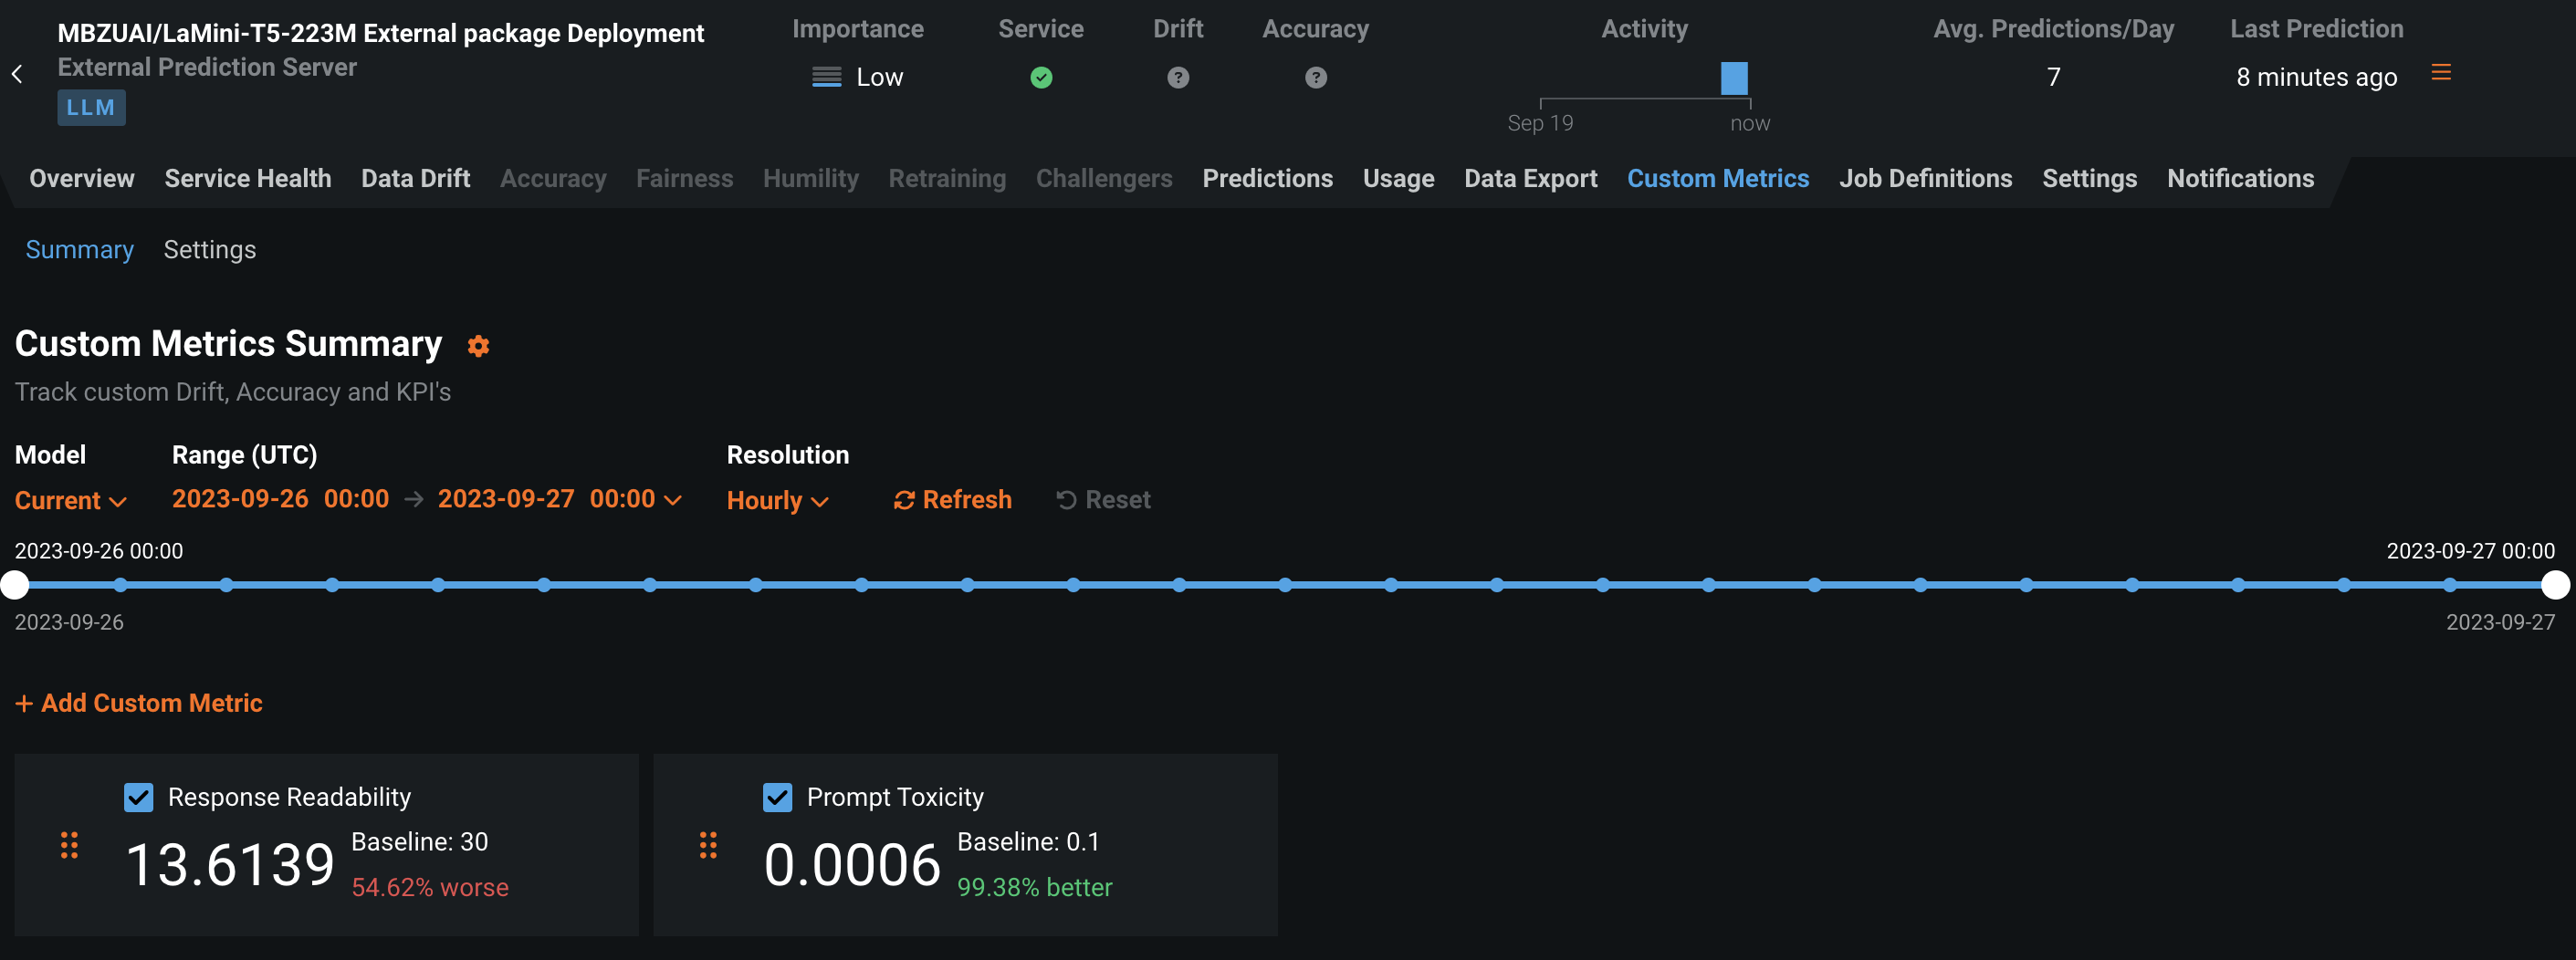

## Conclusion

Using DataRobot's tools for LLMOps, you can implement observability for Huggingface based applications easily with less friction while avoiding increased technical debt.